In [2]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

import gurobipy as gp
from gurobipy import GRB

from general_graph_utils import *

The BHH theorem tells us that if we have a Euclidean manifold on where there is a collection of points we want to visit, which are treated as random variables, then the minimum length of tours that include all points has an upper bound given by the density of points. Having this upper bound guarantees nice behavior.

We seek to understand if we can apply the BHH to asymptotic behavior in transportation applications. Initially, we sought to apply the BHH to the asymptotic behavior of dylays in air transporation networks. To do this, we would associate a probability distribution to each node in the network and understand how delays propagate over time deterministically. 

More recently, we have decided to shift the application to model spatially constrained food delivery as a function of the number of orders.

Consider a set of points $V = \{ x_1, \dots, x_n)$ in $\mathbb{R}^d$, where each $x_i$ is a vertex in a graph and an edge $e = \{x_i, x_j\}$ has length given by the Euclidean distance of the line from $x_i$ to $x_j$, $|e| = |x_i - x_j|$. Consider the functional:

$$L(x_1, \dots, x_n) = \text{min}_{T} \sum_{e \in T} |e| ,$$

where the minimum is over all tours $T$ with vertex set $V$.

**Beardwood-Halton-Hammersley Theorem.** If $x_i$ are i.i.d. random variables with compact support, then with probability one,

$$ \lim_{n \to \infty} L(x_1, \dots, x_n)/n^{(d-1)/d} = \beta_d \int_\mathbb{R^d} f(x)^{(d-1)/d} dx ,$$

where $\beta_d > 0$ is a constant not depending on the distribution of the $x_i$ and where $f$ is the density of the absolutley continuous part of the distribution of the $x_i$. 

The easiest case of the theorem is the 2-dimensional case, where the $x_i$ are uniformly distributed on the unit square with bounded support, meaning that the distribution is zero outside a bounded region. The integrand becomes $1^{1/2} = 1$, and then the integral becomes the volume of a unit cube, which evaluates to 1. The theorem, therefore, says that a uniform distribution of $n$ points in the unit square will almost surely be joined in a tour whose length is asymptotic to $\beta_2 \sqrt{n}$ as $n \to \infty$. 

On the unit square, $d=2$, so we have

$$ \lim_{n \to \infty} \mathbb{E}[L] = \beta_2 \sqrt{n} \int_{D \subset \mathbb{R^2}} 1^{1/2} dx = \beta_2 \sqrt{n} .$$

For the epsilon-constrained version, we want to change $\beta_2$ into something that is a function of epsilon, $\beta_2(\epsilon)$.

First, we need to be able to generate random points on the unit square.

In [19]:
# Generate random points in the unit square
def generate_points(num_points):
    np.random.seed(42)  # For reproducibility
    return np.random.rand(num_points, 2)

We also need to calculate the Euclidean distances between the points.

In [20]:
def calculate_distances(points):
    num_points = len(points)
    distances = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in range(num_points):
            distances[i, j] = np.linalg.norm(points[i] - points[j])
    return distances

A traveling salesman problem (TSP) is based on trying to find the shortest possible route that allows a salesman to visit each of a set of cities exactly once and return to the starting point. In other words, we want to find the minimum tour $T$ for vertex set $V$ (i.e. the functional $L$). 

We can use the optimization framework Gurobi to solve the TSP.

In [21]:
def solve_tsp(distances):
    num_points = len(distances)
    model = gp.Model()

    # Decision variables: x[i, j] is 1 if the tour goes directly from i to j
    x = model.addVars(num_points, num_points, vtype=GRB.BINARY, name="x")

    # Objective: minimize total distance
    model.setObjective(gp.quicksum(distances[i][j] * x[i, j] for i in range(num_points) for j in range(num_points)), GRB.MINIMIZE)

    # Constraints: each node must have exactly one incoming and one outgoing edge
    model.addConstrs(gp.quicksum(x[i, j] for j in range(num_points) if j != i) == 1 for i in range(num_points))
    model.addConstrs(gp.quicksum(x[j, i] for j in range(num_points) if j != i) == 1 for i in range(num_points))

    # Subtour elimination constraints (MTZ formulation)
    u = model.addVars(num_points, vtype=GRB.CONTINUOUS, name="u")
    model.addConstrs((u[i] - u[j] + num_points * x[i, j] <= num_points - 1) for i in range(1, num_points) for j in range(1, num_points) if i != j)

    # Optimize the model
    model.optimize()

    # Extract the solution
    tour = []
    if model.status == GRB.OPTIMAL:
        solution = model.getAttr('x', x)
        for i in range(num_points):
            for j in range(num_points):
                if solution[i, j] > 0.5:  # Edge is part of the tour
                    tour.append((i, j))
    return tour

Finally, we can plot the TSP solution.

In [22]:
# Plot the TSP solution
def plot_solution(points, tour):
    plt.figure(figsize=(8, 8))
    plt.scatter(points[:, 0], points[:, 1], c='red', label='Points')
    for i, (x, y) in enumerate(points):
        plt.text(x, y, str(i), fontsize=12, ha='right')

    for i, j in tour:
        plt.plot([points[i, 0], points[j, 0]], [points[i, 1], points[j, 1]], 'b-')

    plt.title("TSP Solution")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.legend()
    plt.grid(True)
    plt.show()

Let's run this.

[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]]
-
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[rosetta2] - Darwin 23.2.0 23C64)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 92 rows, 110 columns and 396 nonzeros
Model fingerprint: 0xd6d820e8
Variable types: 10 continuous, 100 integer (100 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+01]
  Objective range  [4e-02, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+00]
Found heuristic solution: objective 6.2051739
Presolve removed 0 rows and 11 columns
Presolve time: 0.00s
Presolved: 92 rows, 99 columns, 396 nonzeros
Variable types: 9 continuous, 90 integer (90 binary)

Root relaxation: objective 2.381939e+00, 35 itera

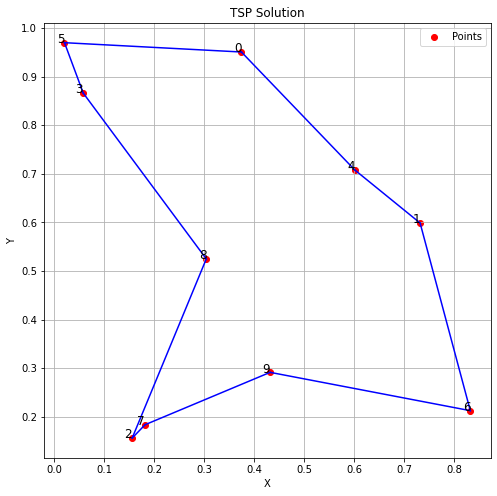

In [27]:
# Main function
def main():
    num_points = 10
    points = generate_points(num_points)
    print(points)
    distances = calculate_distances(points)
    print("-")
    tour = solve_tsp(distances)
    plot_solution(points, tour)

if __name__ == "__main__":
    main()

We can compute the expected tour length using the BHH theorem using the following funtion.

In [18]:
def expected_tour_length_bhh(num_points):
    beta_2 = 0.714  # BHH constant for 2D
    area = 1        # Unit square
    return beta_2 * np.sqrt(num_points)

# Example usage
num_points = 10
expected_length = expected_tour_length_bhh(num_points)
print(f"Expected tour length for {num_points} points: {expected_length:.4f}")

Expected tour length for 10 points: 2.2515


Now, let's implement the epsilon constraint. If two points are within $\epsilon$ of each other, we make them one point.

In [47]:
def epsilon_rejiggering(epsilon, distances, points, num_points):
    for i in range(num_points):
        for j in range(num_points):
            if distances[i, j] <= epsilon:
                print(i,j)
                print(distances[i, j])
                # add a point halfway between the points i and j
                new_point_x = (points[i][0] - points[j][0])/2
                new_point_y = (points[i][1] - points[j][1])/2
                new_point = [new_point_x, new_point_y]
                points = np.append(points, new_point)
                # delete points i and j
                index = [i,j]
                points = np.delete(points, index)
    return points

In [48]:
# Main function
def main():
    num_points = 10
    points = generate_points(num_points)
    print(points)
    distances = calculate_distances(points)
    epsilon = 0.1
    points = epsilon_rejiggering(epsilon, distances, points, num_points)
    print("-")
    tour = solve_tsp(distances)
    plot_solution(points, tour)

if __name__ == "__main__":
    main()

[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]]
0 0
0.0
1 1
0.0


IndexError: invalid index to scalar variable.

In [41]:
points = generate_points(num_points=10)

In [42]:
print(points)

[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]]


In [44]:
points[1][0]

0.7319939418114051

In [5]:
G = nx.DiGraph()
G_size = 8
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

# no flights b/w EWR-LGA, EWR-PHL, PHL-LGA, DCA-IAD, BWI-DCA
# flights from BOS, JFK, IAD to everywhere else
G.add_edge(1,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,3, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(3,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,2, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(2,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,5, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(8,6, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(6,8, weight = np.random.choice(np.arange(1,10), size=1))

G.add_edge(1,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,1, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(4,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,4, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(5,7, weight = np.random.choice(np.arange(1,10), size=1))
G.add_edge(7,5, weight = np.random.choice(np.arange(1,10), size=1))

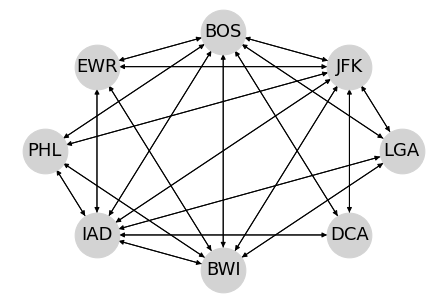

In [6]:
node_labels = {}
node_labels[1] = "LGA"
node_labels[2] = "JFK"
node_labels[3] = "BOS"
node_labels[4] = "EWR"
node_labels[5] = "PHL"
node_labels[6] = "IAD"
node_labels[7] = "BWI"
node_labels[8] = "DCA"
nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

Certain tours will delay the spreading of dealys. A tour in this context is a set of flights that don't go back. A tour of degree 2 is a tour that is not allowed to revisit a node. We can make a more relaxed tour that allows for some backtracking.

One of our goals is figuring out how ot translate BHH (which is a property of the length of a tour) into some aspect of time. The J Michael Steele paper has different types of extensions of the BHH to different types of graphs.

In [80]:
list(nx.eulerian_circuit(G,source=1))

[(1, 7),
 (7, 6),
 (6, 8),
 (8, 3),
 (3, 8),
 (8, 2),
 (2, 8),
 (8, 6),
 (6, 7),
 (7, 5),
 (5, 6),
 (6, 5),
 (5, 7),
 (7, 4),
 (4, 6),
 (6, 4),
 (4, 7),
 (7, 3),
 (3, 6),
 (6, 3),
 (3, 5),
 (5, 3),
 (3, 4),
 (4, 3),
 (3, 7),
 (7, 2),
 (2, 6),
 (6, 2),
 (2, 5),
 (5, 2),
 (2, 4),
 (4, 2),
 (2, 3),
 (3, 2),
 (2, 7),
 (7, 1),
 (1, 6),
 (6, 1),
 (1, 3),
 (3, 1),
 (1, 2),
 (2, 1)]

In [82]:
vertices = [u for u, v in nx.eulerian_circuit(G)]

In [83]:
for i in range(len(vertices)):
    print(node_labels[vertices[i]])

LGA
BWI
IAD
DCA
BOS
DCA
JFK
DCA
IAD
BWI
PHL
IAD
PHL
BWI
EWR
IAD
EWR
BWI
BOS
IAD
BOS
PHL
BOS
EWR
BOS
BWI
JFK
IAD
JFK
PHL
JFK
EWR
JFK
BOS
JFK
BWI
LGA
IAD
LGA
BOS
LGA
JFK
